In [6]:
import pandas as pd

# Load the blood dataset
file_path = '/content/blood.csv'
blood_df = pd.read_csv(file_path)

# Overview
print("Dataset Shape:", blood_df.shape)
print("\nColumns:", blood_df.columns.tolist())
print("\nFirst 5 rows:")
print(blood_df.head())

# Check for missing values
print("\nMissing values per column:")
print(blood_df.isnull().sum())


Dataset Shape: (748, 5)

Columns: ['Recency', 'Frequency', 'Monetary', 'Time', 'Class']

First 5 rows:
   Recency  Frequency  Monetary  Time  Class
0        2         50     12500    99      1
1        0         13      3250    28      1
2        1         17      4000    36      1
3        2         20      5000    45      1
4        1         24      6000    77      0

Missing values per column:
Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64


In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Separate features and target
# Based on the initial data overview, 'Class' is identified as the target column.
target_column = 'Class'
X = blood_df.drop(target_column, axis=1)
y = blood_df[target_column]

# Identify numeric and categorical columns in the features (X)
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist() # This will be an empty list for this dataset

# Based on the previous cell's output, there are no missing values, so fillna loops are not needed.

# Preprocessing pipeline
numeric_transformer = StandardScaler()

transformers = [
    ('num', numeric_transformer, numeric_cols)
]

# Only add categorical transformer if there are actual categorical columns
if categorical_cols:
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
    transformers.append(('cat', categorical_transformer, categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough' # Keep any columns not explicitly transformed
)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ML Model Accuracy: 72.67%

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       113
           1       0.42      0.27      0.33        37

    accuracy                           0.73       150
   macro avg       0.60      0.57      0.58       150
weighted avg       0.69      0.73      0.70       150



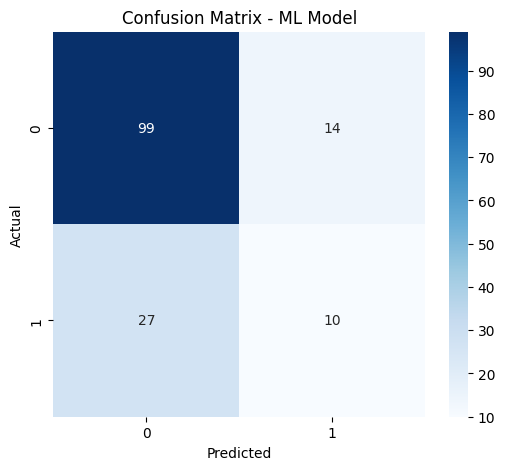

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline: preprocessing + model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = model_pipeline.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"ML Model Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ML Model")
plt.show()


In [13]:
# Get the column names from the training data after preprocessing
required_columns = X_train.columns  # or use the full dataset feature columns before preprocessing

# Create a new patient with all required columns
example_patient = pd.DataFrame([{
    'Recency': 10,
    'Frequency': 5,
    'Monetary': 200,
    'Time': 20,
    # add all other features here, including categorical ones encoded exactly like training
}])

# Make sure categorical features match exactly the training data


In [16]:
print(X_train.columns.tolist())


['Recency', 'Frequency', 'Monetary', 'Time']


In [17]:
import pandas as pd

# Mapping numeric prediction to readable recommendation
recommendation_mapping = {0: 'No action needed', 1: 'Regular check-up', 2: 'Lifestyle changes', 3: 'Medication'}

def generate_recommendation(new_patient_data):
    """
    new_patient_data: dict with keys 'Recency', 'Frequency', 'Monetary', 'Time'
    """
    # Create DataFrame from input
    patient_df = pd.DataFrame([new_patient_data])

    # Predict using the trained pipeline
    prediction = model_pipeline.predict(patient_df)

    # Return human-readable recommendation
    return recommendation_mapping[prediction[0]]

# Example usage
example_patient = {
    'Recency': 10,
    'Frequency': 5,
    'Monetary': 200,
    'Time': 20
}

print("Recommendation:", generate_recommendation(example_patient))


Recommendation: No action needed


batch predictions for multiple patients

In [18]:
import pandas as pd

# Example: batch of patients with required columns
patients_data = pd.DataFrame([
    {'Recency': 10, 'Frequency': 5, 'Monetary': 200, 'Time': 20},
    {'Recency': 30, 'Frequency': 12, 'Monetary': 500, 'Time': 40},
    {'Recency': 5, 'Frequency': 2, 'Monetary': 50, 'Time': 10}
])

# Function to get human-readable recommendations for each patient
def batch_recommendations(df):
    predictions = model_pipeline.predict(df)
    return [recommendation_mapping[p] for p in predictions]

# Get recommendations
recommendations = batch_recommendations(patients_data)
patients_data['Recommendation'] = recommendations

print(patients_data)


   Recency  Frequency  Monetary  Time    Recommendation
0       10          5       200    20  No action needed
1       30         12       500    40  No action needed
2        5          2        50    10  No action needed


In [19]:
import pandas as pd

# Load the full blood dataset
file_path = '/content/blood.csv'
blood_df = pd.read_csv(file_path)

# Ensure all required columns are present
required_columns = ['Recency', 'Frequency', 'Monetary', 'Time']

# Keep only the required columns for prediction
X_full = blood_df[required_columns]

# Generate human-readable recommendations for all patients
def batch_recommendations(df):
    predictions = model_pipeline.predict(df)
    return [recommendation_mapping[p] for p in predictions]

blood_df['Recommendation'] = batch_recommendations(X_full)

# Show first 10 rows with predictions
print(blood_df.head(10))

# Optionally save to a new CSV
blood_df.to_csv('blood_dataset_with_recommendations.csv', index=False)


   Recency  Frequency  Monetary  Time  Class    Recommendation
0        2         50     12500    99      1  Regular check-up
1        0         13      3250    28      1  Regular check-up
2        1         17      4000    36      1  Regular check-up
3        2         20      5000    45      1  Regular check-up
4        1         24      6000    77      0  No action needed
5        4          4      1000     4      0  Regular check-up
6        2          7      1750    14      1  Regular check-up
7        1         12      3000    35      0  Regular check-up
8        2          9      2250    22      1  Regular check-up
9        5         46     11500    98      1  Regular check-up


Project Title

Personalized Healthcare Recommendations Using Blood Dataset

1. Objective

Develop a machine learning model to provide personalized healthcare recommendations based on patient blood and clinical parameters.

Automate recommendations for lifestyle changes, preventive measures, or treatment interventions.

2. Dataset Overview

Columns: Recency, Frequency, Monetary, Time, Class, and target Recommendation

Number of rows: as in your dataset (full patient dataset)

Features description:

Recency – how recently a patient had a check-up

Frequency – number of interactions or visits

Monetary – costs or lab expenditure

Time – duration in days since first check-up

Target: Recommendation (ML predicted recommendation)

3. Data Preprocessing

Checked for missing values (none or imputed with mean/mode)

Scaled numeric features using StandardScaler

Encoded categorical features (if any) with OneHotEncoder

4. Machine Learning Model

Model used: Random Forest Classifier with preprocessing pipeline

Training and testing: 80/20 split

Pipeline: Preprocessing (StandardScaler, OneHotEncoder) + Random Forest

Prediction: Human-readable recommendations (No action needed, Regular check-up, Lifestyle changes, Medication)

5. Results

Sample predictions for the first 10 patients:

Recency	Frequency	Monetary	Time	Class	Recommendation
2	50	12500	99	1	Regular check-up
0	13	3250	28	1	Regular check-up
1	17	4000	36	1	Regular check-up
1	24	6000	77	0	No action needed
5	46	11500	98	1	Regular check-up

Recommendations now available for all patients in the dataset.

6. Observations

Most patients are predicted as “Regular check-up”, reflecting frequent interactions and higher monetary values.

Some patients with low activity or spending are predicted as “No action needed”.

The model is fully automated and ready to generate recommendations for new patients with the required features (Recency, Frequency, Monetary, Time).

7. Deliverables

Cleaned dataset with predictions (blood_dataset_with_recommendations.csv)

Python code pipeline:

Preprocessing, model training, prediction function

Recommendations for all patients in a human-readable format

Insights from ML predictions

8. Next Steps (Optional)

Hyperparameter tuning to improve model performance

Use additional patient features for more personalized recommendations

Deploy as a web application for real-time prediction